In [1]:

%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [2]:
# list of columns to be extracted from Excel table

list_col = ['title', 'issue', 'keywords', 'category']

In [3]:
# uploading 4 columns of interest from Excel table
# the first 500 rows are articles manually classified as 'humanities' or 'natural' (sciences)

md = pd.read_excel('quebecscience_no_inserts_500.xlsx', usecols=list_col)   # uploading columns in 'list_col'
md

,title,issue,keywords,category
0,La fabrique à moustiques,15/07/2023,World Mosquito Program (Projet)\nMoustiques (V...,natural
1,L'antibiorésistance part en voyage,15/07/2023,antibiorésistance,natural
2,Cette limace qui veut conquérir le monde,15/07/2023,Limaces -- Québec (Province)\nAnimaux et plan...,natural
3,Les papillons mangent à midi,15/07/2023,Insectarium de Montréal. Grand Vivarium\nPapi...,natural
4,Pépites toxiques,15/07/2023,Paillettes -- Aspect de l'environnement\nProdu...,natural
...,...,...,...,...
4550,Kung-fu au laboratoire,15/07/1979,Kung-fu -- Physique,NaN
4551,"Gros buveurs, s'abstenir",15/07/1979,Eau potable\nToxicomanie\nHydrologie\nPollutio...,NaN
4552,Une petite bière de trop,15/07/1979,Alcoolisme\nCégeps\nJeunesse québécoise\nTo...,NaN
4553,Sortir des murs ou les repousser,15/07/1979,Psychiatrie -- Québec (Province),NaN


In [32]:
# new DataFrame with only the 'keywords' and 'category' columns that will be used to train RandomForest

chop = ['title']   # the 'title' column will be dropped.

qs = md.drop(chop, axis=1)
qs

,issue,keywords,category
0,15/07/2023,World Mosquito Program (Projet)\nMoustiques (V...,natural
1,15/07/2023,antibiorésistance,natural
2,15/07/2023,Limaces -- Québec (Province)\nAnimaux et plan...,natural
3,15/07/2023,Insectarium de Montréal. Grand Vivarium\nPapi...,natural
4,15/07/2023,Paillettes -- Aspect de l'environnement\nProdu...,natural
...,...,...,...
4550,15/07/1979,Kung-fu -- Physique,NaN
4551,15/07/1979,Eau potable\nToxicomanie\nHydrologie\nPollutio...,NaN
4552,15/07/1979,Alcoolisme\nCégeps\nJeunesse québécoise\nTo...,NaN
4553,15/07/1979,Psychiatrie -- Québec (Province),NaN


In [33]:
# stripping accents lowers precision of algorithm!

# from unidecode import unidecode

# qs['keywords'] = qs['keywords'].apply(unidecode)
# qs

In [34]:
# cleaning the keywords column eliminating '\n'

qs["keywords"] = qs.keywords.apply(lambda x: x.replace("\n", " "))

qs["keywords"] = qs.keywords.apply(lambda x: x.replace(",", ""))  # eliminating comas

qs["keywords"] = qs.keywords.apply(lambda x: x.replace("(", " "))   # eliminating parenthesis

qs["keywords"] = qs.keywords.apply(lambda x: x.replace(")", " "))   # eliminating parenthesis

qs["keywords"] = qs.keywords.apply(lambda x: x.replace("--", ""))   # eliminating parenthesis

qs["keywords"] = qs.keywords.apply(lambda x: x.replace("-", " "))   # eliminating parenthesis

qs["keywords"] = qs.keywords.apply(lambda x: x.replace(":", ""))   # eliminating columns

qs["keywords"] = qs.keywords.apply(lambda x: x.replace("l'", ""))   # eliminating apostrohes

qs["keywords"] = qs.keywords.apply(lambda x: x.replace("*", ""))   # eliminating *

qs["keywords"] = qs.keywords.apply(lambda x: x.replace("+", ""))   # eliminating +

In [35]:
qs

,issue,keywords,category
0,15/07/2023,World Mosquito Program Projet Moustiques Ve...,natural
1,15/07/2023,antibiorésistance,natural
2,15/07/2023,Limaces Québec Province Animaux et plantes...,natural
3,15/07/2023,Insectarium de Montréal. Grand Vivarium Papil...,natural
4,15/07/2023,Paillettes Aspect de environnement Produits d...,natural
...,...,...,...
4550,15/07/1979,Kung fu Physique,NaN
4551,15/07/1979,Eau potable Toxicomanie Hydrologie Pollution d...,NaN
4552,15/07/1979,Alcoolisme Cégeps Jeunesse québécoise Toxic...,NaN
4553,15/07/1979,Psychiatrie Québec Province,NaN


### Machine learning with RandomForestClassifier

In [36]:
# extraction of the first 500 rows that include the articles manually classified as belonging to humanities or natural sciences.

qs_analyse = qs.loc[:501]
# qs_analyse.info()
qs_analyse

,issue,keywords,category
0,15/07/2023,World Mosquito Program Projet Moustiques Ve...,natural
1,15/07/2023,antibiorésistance,natural
2,15/07/2023,Limaces Québec Province Animaux et plantes...,natural
3,15/07/2023,Insectarium de Montréal. Grand Vivarium Papil...,natural
4,15/07/2023,Paillettes Aspect de environnement Produits d...,natural
...,...,...,...
497,15/11/2016,Chimie végétale Composés bioactifs végéta...,natural
498,15/11/2016,Perreault Jacques Sites archéologiques Grèc...,humanities
499,15/11/2016,Empirisme Sciences Parasciences Modèles des c...,humanities
500,15/11/2016,Obésité Étiologie et facteurs de risque Ob...,humanities


In [37]:
# extraction of the classification values of the training data

predictions1 = qs_analyse['category']
predictions1

0         natural
1         natural
2         natural
3         natural
4         natural
          ...    
497       natural
498    humanities
499    humanities
500    humanities
501       natural
Name: category, Length: 502, dtype: object

In [38]:
# qs_analyse.keywords

In [39]:
# qs_analyse.category

In [40]:
# algorithm trained on words column using the information in column 'category' as criteria

x, y = qs_analyse.keywords, qs_analyse.category
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=0)   # 10% of the classified articles for verification

# print(x_train)
# print(y_train)
# x_test
# y_test

In [41]:
# a maximum of 1000 words will be used to create the classification vocabulary.
# only the words that will occur at least three times in all the bags of keywords will be taken into account for the construction of the vocabulary
# and the words that occur 70% and more often amongst keywords will be eleminated as irrelevant and not included in the classification vocabulary.

converter = TfidfVectorizer(max_features=1000, min_df=3, max_df=0.7, encoding="utf-8")
converter.fit(x_train)

TfidfVectorizer(max_df=0.7, max_features=1000, min_df=3)

### Calculating the frequency of each significant word 

### Each word in each set of keywords describing an article is attributed a frequency

In [42]:
# the 'converter' calculates the frequency of each word within the classification vocabulary (max: 1000 words) 
# and maps these frequencies for each word from each 'bag of keywords'.
# the bag of keywords describing an article becomes a list of the probabilities for each keyword.

x_train_converted = converter.transform(x_train)
x_train_converted = converter.transform(x_train).toarray()

# x_train_converted[0]   # displays the matrix of the frequencies of the keywords for a first bag of keywords describing an article.

# len(x_train_converted[0])
# len(x_train_converted)
# converter.get_feature_names()    # in order to extract the significant words used by the RandomForestclassifier
# len(converter.get_feature_names())
# y_train_converted = converter.transform(y_train).toarray()
# y_train_converted
# len(y_train_converted)

In [43]:
# RandomForest will create a maximum of 1000 classification trees.

classifier = RandomForestClassifier(n_estimators=1000, random_state=0, oob_score=True)

# algorithm trains on the frequencies of words and looks for relationships with each category

In [44]:
classifier.fit(x_train_converted, y_train)

RandomForestClassifier(n_estimators=1000, oob_score=True, random_state=0)

In [45]:
# transformation of the test kewwords in frequencies.

x_test_converted = converter.transform(x_test).toarray()
# x_test_converted

In [46]:
# verification if the algorithm corectly classifies the 'bag of words' of unclassified articles

y_pred = classifier.predict(x_test_converted)
# y_pred

In [47]:
# printing of reports on the performance of the algorithm by comparing predictions with already classified articles

print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

  humanities       0.91      0.59      0.71        17
     natural       0.82      0.97      0.89        34

    accuracy                           0.84        51
   macro avg       0.87      0.78      0.80        51
weighted avg       0.85      0.84      0.83        51

0.8431372549019608


In [48]:
# extraction of the keywords of the uncategorized articles

qs_unclassified_keywords = qs[502:].keywords

In [49]:
# conversion of the unclassified bags of keywords into their frequencies for each article

qs_unclassified_keywords_converted = converter.transform(qs_unclassified_keywords).toarray()
qs_unclassified_keywords_converted

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [56]:
# algorithm RandonForest is asked to classify the bulk of the articles 

predictions = classifier.predict(qs_unclassified_keywords_converted)
len(predictions)

4053

In [57]:
# that makes available categorization for all 4555 articles

print(len(predictions1))
print(len(predictions))

502
4053


In [58]:
# merging of classification data into one column for all 4555 articles.

predictions = np.concatenate([predictions1, predictions])
print(len(predictions))
predictions

4555


array(['natural', 'natural', 'natural', ..., 'natural', 'natural',
       'natural'], dtype=object)

In [59]:
# all articles in the original dataframe are classified as 'natural sciences' or 'humanities'

qs['category'] = predictions
qs.info()
qs

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4555 entries, 0 to 4554
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   issue     4555 non-null   object
 1   keywords  4555 non-null   object
 2   category  4555 non-null   object
dtypes: object(3)
memory usage: 106.9+ KB


,issue,keywords,category
0,15/07/2023,World Mosquito Program Projet Moustiques Ve...,natural
1,15/07/2023,antibiorésistance,natural
2,15/07/2023,Limaces Québec Province Animaux et plantes...,natural
3,15/07/2023,Insectarium de Montréal. Grand Vivarium Papil...,natural
4,15/07/2023,Paillettes Aspect de environnement Produits d...,natural
...,...,...,...
4550,15/07/1979,Kung fu Physique,natural
4551,15/07/1979,Eau potable Toxicomanie Hydrologie Pollution d...,natural
4552,15/07/1979,Alcoolisme Cégeps Jeunesse québécoise Toxic...,natural
4553,15/07/1979,Psychiatrie Québec Province,natural


In [60]:
# one on one verification of the classification using index value to retrieve specific article and its 'algorithmic' category.
# articles have been categorized by the algorithm from row 501 to 4554
# index number delivers the bag of keywords and the category 'according to RandomForeest'. 

index = 1114

print(qs.iloc[index].keywords)
print(qs.iloc[index].category)

Banques de cerveaux  Québec  Province  Cerveau  Recherche  Québec  Province  Dons d'organes de tissus etc.  Québec  Province 
natural


In [61]:
# extraction of the most significat words of the classification vocabulary

classifier.feature_importances_
converter.get_feature_names_out()

# creation of a DataFrame with these as columns which will rate the importance of the word in its capacity to categorize the bags of keywords.

pd.DataFrame(index=converter.get_feature_names_out(), data=classifier.feature_importances_).sort_values(by=0, ascending=False).head(25)

,0
histoire,0.068467
sciences,0.035649
politique,0.027190
social,0.026268
recherche,0.023276
psychologique,0.020639
aspect,0.019259
des,0.017383
de,0.017261
moral,0.015030


# Extraction des articles sces naturelles et sces humaines

In [62]:
# segregation of 'natural' and 'humanities' articles

qs_a = qs.sort_values(by=['category'],ignore_index=True)
qs_a

,issue,keywords,category
0,15/12/1981,Vidéo Appareils et matériel Vidéodisques M...,humanities
1,15/10/1987,Agronomie Québec Province Histoire,humanities
2,15/10/1987,Sciences Vulgarisation Québec Province,humanities
3,15/03/2010,Darwinisme Créationnisme Pays musulmans Evol...,humanities
4,15/03/2010,Dansereau Pierre Ecologistes Québec Provinc...,humanities
...,...,...,...
4550,15/04/2000,Québec Province . Ministère de Environnemen...,natural
4551,15/04/2000,Vie artificielle Bactéries Ressources géné...,natural
4552,15/04/2000,Douleur chez enfant Douleur Traitement Morphi...,natural
4553,15/05/2000,Aubin Gérard Fromage Québec Province Orl...,natural


In [63]:
# there are 928 articles classified 'humanities'

qs_h = qs_a.loc[(qs_a["category"] == "humanities")]
qs_h

,issue,keywords,category
0,15/12/1981,Vidéo Appareils et matériel Vidéodisques M...,humanities
1,15/10/1987,Agronomie Québec Province Histoire,humanities
2,15/10/1987,Sciences Vulgarisation Québec Province,humanities
3,15/03/2010,Darwinisme Créationnisme Pays musulmans Evol...,humanities
4,15/03/2010,Dansereau Pierre Ecologistes Québec Provinc...,humanities
...,...,...,...
1054,15/11/1992,Enseignement professionnel Collégial Québ...,humanities
1055,15/12/2022,Brunelle François Photographes Québec Prov...,humanities
1056,15/08/1981,Communication subliminale Inconscient Publicit...,humanities
1057,15/12/2016,Interfaces cerveau ordinateur Recherche Cerve...,humanities


In [67]:
# extraction of articles classified as 'natural sciences'

qs_n = qs_a.loc[(qs_a["category"] == "natural")]
qs_n

,issue,keywords,category
1059,15/06/1986,Insecticides biologiques Bactéries Mutation ...,natural
1060,15/09/1986,Lieberman Robert Psychiatrie Schizophrénie T...,natural
1061,15/10/1991,Radarsat Satellite de télédétection Satel...,natural
1062,15/03/1991,Balles et ballons Mécanique,natural
1063,15/04/1992,Vaccins contre la méningite Méningite Québ...,natural
...,...,...,...
4550,15/04/2000,Québec Province . Ministère de Environnemen...,natural
4551,15/04/2000,Vie artificielle Bactéries Ressources géné...,natural
4552,15/04/2000,Douleur chez enfant Douleur Traitement Morphi...,natural
4553,15/05/2000,Aubin Gérard Fromage Québec Province Orl...,natural


### Objective of this section of the script:
Creation of two separate files, indicating for each issue of the magazine the number of articles in natural sciences or the humanities,
Dates of publication (from column 'issue') will be proxies for each article.
For each issue, i.e for each date : total number of humanities articles will be total of rows with same date' classified as 'humanities;
                                    total number of natural sciences articles will be total of rows also with same date classified 'natural'.

In [72]:
# the publishing date of each humanities article will be a proxy for the article 

qs_h_dates = qs_h.loc[:,'issue':'issue']
qs_h_dates.info()
qs_h_dates

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1059 entries, 0 to 1058
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   issue   1059 non-null   object
dtypes: object(1)
memory usage: 16.5+ KB


,issue
0,15/12/1981
1,15/10/1987
2,15/10/1987
3,15/03/2010
4,15/03/2010
...,...
1054,15/11/1992
1055,15/12/2022
1056,15/08/1981
1057,15/12/2016


In [76]:
# renaming as 'date'

qs_h_dates = qs_h_dates.rename(columns={"issue": "date"})
qs_h_dates

,date
0,15/12/1981
1,15/10/1987
2,15/10/1987
3,15/03/2010
4,15/03/2010
...,...
1054,15/11/1992
1055,15/12/2022
1056,15/08/1981
1057,15/12/2016


In [77]:
# extraction of publication dates for all natural sciences articles
# each publishing date of a natural sciences article will be a proxy for the article.

qs_n_dates = qs_n.loc[:,'issue':'issue']
qs_n_dates.info()
qs_n_dates

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3496 entries, 1059 to 4554
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   issue   3496 non-null   object
dtypes: object(1)
memory usage: 54.6+ KB


,issue
1059,15/06/1986
1060,15/09/1986
1061,15/10/1991
1062,15/03/1991
1063,15/04/1992
...,...
4550,15/04/2000
4551,15/04/2000
4552,15/04/2000
4553,15/05/2000


In [79]:
# renaming column as 'date'

qs_n_dates = qs_n_dates.rename(columns={'issue':'date'})
qs_n_dates

,date
1059,15/06/1986
1060,15/09/1986
1061,15/10/1991
1062,15/03/1991
1063,15/04/1992
...,...
4550,15/04/2000
4551,15/04/2000
4552,15/04/2000
4553,15/05/2000


In [80]:
# summing up the number of humanities articles per issue of the magazine.

qs_h_dates_sum = qs_h_dates.value_counts()            # sums up similar dates
qs_h_dates_sum = qs_h_dates_sum.reset_index(level=0)  # we create a new indexing column
qs_h_dates_sum = qs_h_dates_sum.rename(columns={0: 'humanities'})

# output is dataframe with total number of humanities articles for each date 
print(qs_h_dates_sum.info())
qs_h_dates_sum 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        392 non-null    object
 1   humanities  392 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 6.2+ KB
None


,date,humanities
0,15/06/2008,14
1,15/10/2004,12
2,15/09/1999,11
3,15/10/2005,9
4,15/12/2002,9
...,...,...
387,15/09/2006,1
388,15/04/1983,1
389,15/04/1984,1
390,15/04/1987,1


In [ ]:
# index becomes dates of publications

ind = ["date"]
qs_h_dates_sum.set_index(ind, drop=True, inplace=True)
qs_h_dates_sum

,humanities
date,
15/06/2008,14
15/10/2004,12
15/09/1999,11
15/10/2005,9
15/12/2002,9
...,...
15/09/2006,1
15/04/1983,1
15/04/1984,1


### We repeat the process for the natural sciences articles

In [82]:
# summing up the number of natural sciences articles per issue

qs_n_dates_sum = qs_n_dates.value_counts()
qs_n_dates_sum = qs_n_dates_sum.reset_index(level=0)  # on rajoute un index de 0 à 380
qs_n_dates_sum = qs_n_dates_sum.rename(columns={0: 'natural'})

qs_n_dates_sum 

,date,natural
0,15/12/1983,20
1,15/07/1981,18
2,15/07/1979,18
3,15/11/1984,17
4,15/09/1979,17
...,...,...
426,15/02/2008,1
427,15/12/2008,1
428,15/11/1991,1
429,15/11/2014,1


In [83]:
# indexing with the date column for the natural sciences articles

ind = ["date"]
qs_n_dates_sum.set_index(ind, drop=True, inplace=True)
qs_n_dates_sum

,natural
date,
15/12/1983,20
15/07/1981,18
15/07/1979,18
15/11/1984,17
15/09/1979,17
...,...
15/02/2008,1
15/12/2008,1
15/11/1991,1


In [84]:
# We end up with 431 issues that include natural sciences articles

qs_n_dates_sum.info()

<class 'pandas.core.frame.DataFrame'>
Index: 431 entries, 15/12/1983 to 15/03/2021
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   natural  431 non-null    int64
dtypes: int64(1)
memory usage: 6.7+ KB


In [85]:
# but only 392 issues, 47 less, include humanities articles

qs_h_dates_sum.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392 entries, 15/06/2008 to 15/10/1990
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   humanities  392 non-null    int64
dtypes: int64(1)
memory usage: 6.1+ KB


In [86]:
# sorting dates of humanities from the earliest

qs_h_dates_sum.sort_index(axis=0, ascending=True, inplace=True)
qs_h_dates_sum

,humanities
date,
15/01/1980,2
15/01/1981,3
15/01/1982,2
15/01/1983,2
15/01/1984,1
...,...
15/12/2018,5
15/12/2019,2
15/12/2020,3


In [87]:
# sorting out the publishing dates for natural sciences articles

qs_n_dates_sum.sort_index(axis=0, ascending=True, inplace=True)
qs_n_dates_sum

,natural
date,
15/01/1980,11
15/01/1981,15
15/01/1982,10
15/01/1983,16
15/01/1984,14
...,...
15/12/2018,7
15/12/2019,4
15/12/2020,4


# Objective of this part of the script:
Create graphic representations of the number of each category of articles over 44 years.

# Challenge : 
create a dataframe that for each of the 431 issues will indicate the respective numbers of 'natural' and 'humanities' articles. We will therefore match the 'humanities' columns with the 'natural sciences' such that issues without any humanities articles will be included.

In [89]:
# merging of the humanities publishing dates on the natural sciences publishing dates.
# both categories share same chronology even though several issues did not include any humanities articles, indicated by NaN.

dte = [qs_n_dates_sum, qs_h_dates_sum]

d = pd.concat(dte, axis=1, join='outer')

# d = qs_n_dates_sum.merge(qs_h_dates_sum, left_index=True, right_index=False)

d.info()
d.head(60)

<class 'pandas.core.frame.DataFrame'>
Index: 431 entries, 15/01/1980 to 15/12/2022
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   natural     431 non-null    int64  
 1   humanities  392 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 10.1+ KB


,natural,humanities
date,,
15/01/1980,11,2.0
15/01/1981,15,3.0
15/01/1982,10,2.0
15/01/1983,16,2.0
15/01/1984,14,1.0
15/01/1985,14,2.0
15/01/1986,13,1.0
15/01/1987,10,NaN
15/01/1988,11,1.0


In [90]:
# sorting of the date index

d.sort_index(axis=0, ascending=True, inplace=True)
print(d.info())
d

<class 'pandas.core.frame.DataFrame'>
Index: 431 entries, 15/01/1980 to 15/12/2022
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   natural     431 non-null    int64  
 1   humanities  392 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 10.1+ KB
None


,natural,humanities
date,,
15/01/1980,11,2.0
15/01/1981,15,3.0
15/01/1982,10,2.0
15/01/1983,16,2.0
15/01/1984,14,1.0
...,...,...
15/12/2018,7,5.0
15/12/2019,4,2.0
15/12/2020,4,3.0


In [91]:
# NaN values are replaced by very small number to homogenize numbers and eliminate any risk of dividing by 0.

d = d.fillna(0.01)
d.info()
d.head()

<class 'pandas.core.frame.DataFrame'>
Index: 431 entries, 15/01/1980 to 15/12/2022
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   natural     431 non-null    int64  
 1   humanities  431 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 10.1+ KB


,natural,humanities
date,,
15/01/1980,11,2.0
15/01/1981,15,3.0
15/01/1982,10,2.0
15/01/1983,16,2.0
15/01/1984,14,1.0


### Creation of two separate files for natural and humanities articles in order to produce graphs showing how each category evolved over time.

In [92]:
# dates made into a column

d.reset_index(inplace=True)
d

,date,natural,humanities
0,15/01/1980,11,2.0
1,15/01/1981,15,3.0
2,15/01/1982,10,2.0
3,15/01/1983,16,2.0
4,15/01/1984,14,1.0
...,...,...,...
426,15/12/2018,7,5.0
427,15/12/2019,4,2.0
428,15/12/2020,4,3.0
429,15/12/2021,4,4.0


In [93]:
# creation of file exclusively for humanities articles

dh = d.drop('natural', axis=1)
dh

,date,humanities
0,15/01/1980,2.0
1,15/01/1981,3.0
2,15/01/1982,2.0
3,15/01/1983,2.0
4,15/01/1984,1.0
...,...,...
426,15/12/2018,5.0
427,15/12/2019,2.0
428,15/12/2020,3.0
429,15/12/2021,4.0


In [94]:
# creation of file exclusively made of natural sciences articles

dn = d.drop("humanities", axis=1)
dn

,date,natural
0,15/01/1980,11
1,15/01/1981,15
2,15/01/1982,10
3,15/01/1983,16
4,15/01/1984,14
...,...,...
426,15/12/2018,7
427,15/12/2019,4
428,15/12/2020,4
429,15/12/2021,4


In [95]:
# dates translated in dateline format

dh['date'] = pd.to_datetime(dh['date'], format='%d/%m/%Y')
dh

,date,humanities
0,1980-01-15,2.0
1,1981-01-15,3.0
2,1982-01-15,2.0
3,1983-01-15,2.0
4,1984-01-15,1.0
...,...,...
426,2018-12-15,5.0
427,2019-12-15,2.0
428,2020-12-15,3.0
429,2021-12-15,4.0


In [96]:
# datetime indexing for the humanities

dh.date = (pd.to_datetime(dh.date.values, unit="m").tz_localize('UTC'))
dh = dh.set_index("date")
dh.head()

,humanities
date,
1980-01-15 00:00:00+00:00,2.0
1981-01-15 00:00:00+00:00,3.0
1982-01-15 00:00:00+00:00,2.0
1983-01-15 00:00:00+00:00,2.0
1984-01-15 00:00:00+00:00,1.0


In [97]:
# chronological sorting

dh.sort_index(axis=0, ascending=True, inplace=True)
dh.tail(60)
# dh.info()

,humanities
date,
2016-03-15 00:00:00+00:00,2.00
2016-04-15 00:00:00+00:00,2.00
2016-06-15 00:00:00+00:00,4.00
2016-08-15 00:00:00+00:00,1.00
2016-10-15 00:00:00+00:00,0.01
2016-11-15 00:00:00+00:00,4.00
2016-12-15 00:00:00+00:00,3.00
2017-01-15 00:00:00+00:00,2.00
2017-03-15 00:00:00+00:00,4.00


In [98]:
# formatting date column of natural sciences for datetime

dn['date'] = pd.to_datetime(dn['date'], format='%d/%m/%Y')
dn

,date,natural
0,1980-01-15,11
1,1981-01-15,15
2,1982-01-15,10
3,1983-01-15,16
4,1984-01-15,14
...,...,...
426,2018-12-15,7
427,2019-12-15,4
428,2020-12-15,4
429,2021-12-15,4


In [99]:
# datetime index for the natural sciences articles

dn.date = (pd.to_datetime(dn.date.values, unit="m").tz_localize('UTC'))
dn = dn.set_index("date")
dn.head()                                            

,natural
date,
1980-01-15 00:00:00+00:00,11
1981-01-15 00:00:00+00:00,15
1982-01-15 00:00:00+00:00,10
1983-01-15 00:00:00+00:00,16
1984-01-15 00:00:00+00:00,14


In [100]:
# sorting on dates

dn.sort_index(axis=0, ascending=True, inplace=True)
dn.head(60)
dn.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 431 entries, 1979-05-15 00:00:00+00:00 to 2023-07-15 00:00:00+00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   natural  431 non-null    int64
dtypes: int64(1)
memory usage: 6.7 KB


### Production of graphs showing trends in the publication of natural sciences and humanities articles 

In [101]:
# summing up number of humanities articles per year
# on cumule le nombre d'articles par année en sces humaines

# dh_year = dh.resample("Y").mean()
# dh_year.columns = ["humaines (moy. ann.)"]

In [102]:
# summing up number of natural sciences articles per year
# on cumule le nombre d'articles par année en sces naturelles.

# dn_year = dn.resample("Y").mean()
# dn_year.columns = ["naturelles (moy. ann.)"]

In [103]:
# substracting the number of humanities articles from the natural sciences articles
# on crée les valeurs de la courbe de la différence de fréquence des articles 'hum' et 'nat' selon les années.

# dnf_diff = (dn.resample("Y").mean().naturelles - dh.resample("Y").mean().humaines)

In [104]:
# more explicite ratio of numanities to natural sciences articles
# le ratio du nombre d'articles en sces humaines divisé par le nombre d'articles en sces naturelles.

# dnf_ratio = (dh.resample("Y").mean().humaines / dn.resample("Y").mean().naturelles)

In [105]:


import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('ggplot')
import seaborn as sns
import datetime

# Trends with 2-year periods sampling of total number of articles

In [116]:
# to moderately smooth the curves we sampled of 2-year periods : total of humanities articles per two-year periods 

dhS_2year = dh.resample("2Y").sum()
dhS_2year.columns = ["humanities (2Y-periods)"]
dhS_2year

,humanities (2Y-periods)
date,
1979-12-31 00:00:00+00:00,17.00
1981-12-31 00:00:00+00:00,60.00
1983-12-31 00:00:00+00:00,51.02
1985-12-31 00:00:00+00:00,49.02
1987-12-31 00:00:00+00:00,39.03
1989-12-31 00:00:00+00:00,34.05
1991-12-31 00:00:00+00:00,24.08
1993-12-31 00:00:00+00:00,51.01
1995-12-31 00:00:00+00:00,50.01


In [117]:
dnS_2year = dn.resample("2Y").sum()
dnS_2year.columns = ["natural (2Y-periods)"]
dnS_2year

,natural (2Y-periods)
date,
1979-12-31 00:00:00+00:00,90
1981-12-31 00:00:00+00:00,350
1983-12-31 00:00:00+00:00,310
1985-12-31 00:00:00+00:00,281
1987-12-31 00:00:00+00:00,240
1989-12-31 00:00:00+00:00,191
1991-12-31 00:00:00+00:00,111
1993-12-31 00:00:00+00:00,148
1995-12-31 00:00:00+00:00,143


In [118]:
# ratio of the numbers of the two categories which remains meaningful even for fractions of years.
# a value of 1.0000 would indicate a 2-year period durnig which identical numbers of humanities and natural sces articles were published.

hnS_2year_ratio = (dh.resample("2Y").sum().humanities / dn.resample("2Y").sum().natural)
hnS_2year_ratio.columns = ["ratio human/natur 2y"]
hnS_2year_ratio

date
1979-12-31 00:00:00+00:00    0.188889
1981-12-31 00:00:00+00:00    0.171429
1983-12-31 00:00:00+00:00    0.164581
1985-12-31 00:00:00+00:00    0.174448
1987-12-31 00:00:00+00:00    0.162625
1989-12-31 00:00:00+00:00    0.178272
1991-12-31 00:00:00+00:00    0.216937
1993-12-31 00:00:00+00:00    0.344662
1995-12-31 00:00:00+00:00    0.349720
1997-12-31 00:00:00+00:00    0.320881
1999-12-31 00:00:00+00:00    0.409357
2001-12-31 00:00:00+00:00    0.288412
2003-12-31 00:00:00+00:00    0.438849
2005-12-31 00:00:00+00:00    0.390781
2007-12-31 00:00:00+00:00    0.284846
2009-12-31 00:00:00+00:00    0.555926
2011-12-31 00:00:00+00:00    0.310100
2013-12-31 00:00:00+00:00    0.495146
2015-12-31 00:00:00+00:00    0.385521
2017-12-31 00:00:00+00:00    0.420654
2019-12-31 00:00:00+00:00    0.593140
2021-12-31 00:00:00+00:00    0.679487
2023-12-31 00:00:00+00:00    0.630952
Freq: 2A-DEC, dtype: float64

In [119]:
# this function will help flatten some data to make it palatable to matplotlib and calculation of p-value

def flatten_list(nested_list):
    flat_list = []
    for sublist in nested_list:
        for item in sublist:
            flat_list.append(item)
    return flat_list


In [120]:
# natural sciences 2-year sums made into unidimensional list

y1 = dnS_2year.values  
print(type(y1))
print(y1)
y3 = y1.tolist()
print(type(y3))
print(y3)
y5 = flatten_list(y3)
print(type(y5))
print(len(y5))

<class 'numpy.ndarray'>
[[ 90]
 [350]
 [310]
 [281]
 [240]
 [191]
 [111]
 [148]
 [143]
 [159]
 [171]
 [170]
 [139]
 [128]
 [130]
 [ 81]
 [100]
 [103]
 [ 96]
 [107]
 [ 86]
 [ 78]
 [ 84]]
<class 'list'>
[[90], [350], [310], [281], [240], [191], [111], [148], [143], [159], [171], [170], [139], [128], [130], [81], [100], [103], [96], [107], [86], [78], [84]]
<class 'list'>
23


In [121]:
# discarding first and last totals since they include only part of a year.

y7 = y5[1:-1]
print(len(y7))
y7

21


[350,
 310,
 281,
 240,
 191,
 111,
 148,
 143,
 159,
 171,
 170,
 139,
 128,
 130,
 81,
 100,
 103,
 96,
 107,
 86,
 78]

In [122]:
# unidimensional list made from yearly humanities counts

y2 = dhS_2year.values
print(type(y2))
print(y2)
y4 = y2.tolist()
print(type(y4))
y6 = flatten_list(y4)
print(type(y6))
print(len(y6))

<class 'numpy.ndarray'>
[[17.  ]
 [60.  ]
 [51.02]
 [49.02]
 [39.03]
 [34.05]
 [24.08]
 [51.01]
 [50.01]
 [51.02]
 [70.  ]
 [49.03]
 [61.  ]
 [50.02]
 [37.03]
 [45.03]
 [31.01]
 [51.  ]
 [37.01]
 [45.01]
 [51.01]
 [53.  ]
 [53.  ]]
<class 'list'>
<class 'list'>
23


In [123]:
# discarding first and last totals since they include only fractions of the year

y8 = y6[1:-1]
print(len(y8))
y8

21


[60.0,
 51.02,
 49.019999999999996,
 39.03,
 34.05,
 24.08,
 51.01,
 50.01,
 51.019999999999996,
 70.0,
 49.03,
 61.0,
 50.019999999999996,
 37.03,
 45.03,
 31.009999999999998,
 51.0,
 37.01,
 45.01,
 51.01,
 53.0]

In [124]:
# creation of one-dimensional list of ratios

hnS_2year_ratio
r = hnS_2year_ratio.values
# print(type(r))
# print(r)
r1 = r.tolist()
print(type(r1))
print(r1)
r2 = r1[1:-1]
print(len(r2))
r2

<class 'list'>
[0.18888888888888888, 0.17142857142857143, 0.16458064516129034, 0.17444839857651245, 0.162625, 0.1782722513089005, 0.2169369369369369, 0.34466216216216217, 0.3497202797202797, 0.32088050314465405, 0.4093567251461988, 0.28841176470588237, 0.43884892086330934, 0.39078124999999997, 0.28484615384615386, 0.5559259259259259, 0.3101, 0.49514563106796117, 0.3855208333333333, 0.42065420560747663, 0.593139534883721, 0.6794871794871795, 0.6309523809523809]
21


[0.17142857142857143,
 0.16458064516129034,
 0.17444839857651245,
 0.162625,
 0.1782722513089005,
 0.2169369369369369,
 0.34466216216216217,
 0.3497202797202797,
 0.32088050314465405,
 0.4093567251461988,
 0.28841176470588237,
 0.43884892086330934,
 0.39078124999999997,
 0.28484615384615386,
 0.5559259259259259,
 0.3101,
 0.49514563106796117,
 0.3855208333333333,
 0.42065420560747663,
 0.593139534883721,
 0.6794871794871795]

In [125]:
# creation of the timespan wich will become the time (horizontal) axis of the graphs

t = np.linspace(1979, 2023, 21)
t1 = t.tolist()
print(len(t1))
t1

21


[1979.0,
 1981.2,
 1983.4,
 1985.6,
 1987.8,
 1990.0,
 1992.2,
 1994.4,
 1996.6,
 1998.8,
 2001.0,
 2003.2,
 2005.4,
 2007.6,
 2009.8,
 2012.0,
 2014.2,
 2016.4,
 2018.6,
 2020.8,
 2023.0]

In [ ]:
from matplotlib.text import OffsetFrom

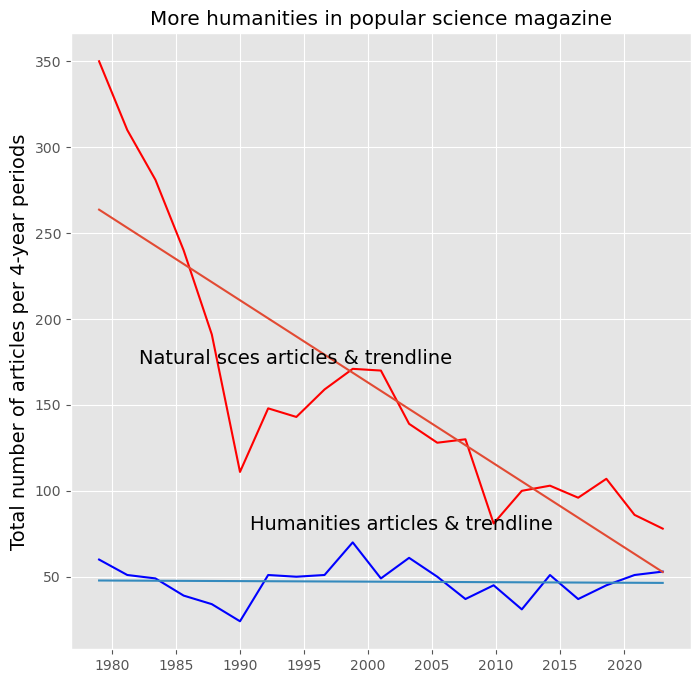

In [126]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

x = t1      # time sapn
y1 = y7     # total of natural sces articles per 2-year periods
y2 = y8     # total of humanities articles per 2-year periods
y3 = r2     # ratio of the totals :totals of humanities articles divided by totals of natural sces articles

ax.set_title("More humanities in popular science magazine")
ax.plot(x, y1, color="red", linewidth=1.5, linestyle="-")
ax.annotate("Humanities articles & trendline",
            xy=(180, 110), xycoords="figure points",
            fontsize=14)
ax.plot(x, y2, color="blue", linewidth=1.5, linestyle="-")
ax.annotate('Natural sces articles & trendline',
            xy=(100, 230), xycoords='figure points',
            fontsize=14)
# ax.plot(x, y3)
z = np.polyfit(x, y1, 1)
p = np.poly1d(z)
plt.plot(x, p(x))
u = np.polyfit(x, y2, 1)
v = np.poly1d(u)
plt.plot(x, v(x))
# m = np.polyfit(x, y3, 1)
# n = np.poly1d(m)
# plt.plot(x, n(x))
# ax.annotate('Ratio Social/Natural is increasing, albeit slowly',
#            xy=(330, 60), xycoords='figure points',
#            fontsize=14)
ax.set_ylabel("Total number of articles per 4-year periods", fontsize=14)
ax.set_xticks([1980, 1985, 1990, 1995, 2000, 2005, 2010, 2015, 2020])
fig.savefig("Humanities growing presence in popular science magazine.png")

# Resampling to produce trend of ratio 

In [128]:
# sampling over 4-year periods to smooth the curve

hnS_4year_ratio = (dh.resample("4Y").sum().humanities / dn.resample("4Y").sum().natural)
hnS_4year_ratio.columns = ["ratio human/natur 4y"]
hnS_4year_ratio

date
1979-12-31 00:00:00+00:00    0.188889
1983-12-31 00:00:00+00:00    0.168212
1987-12-31 00:00:00+00:00    0.169002
1991-12-31 00:00:00+00:00    0.192483
1995-12-31 00:00:00+00:00    0.347148
1999-12-31 00:00:00+00:00    0.366727
2003-12-31 00:00:00+00:00    0.356084
2007-12-31 00:00:00+00:00    0.337403
2011-12-31 00:00:00+00:00    0.420110
2015-12-31 00:00:00+00:00    0.442261
2019-12-31 00:00:00+00:00    0.497513
2023-12-31 00:00:00+00:00    0.654321
Freq: 4A-DEC, dtype: float64

In [130]:
# flattening of ratios

hnS_4year_ratio
r = hnS_4year_ratio.values
# print(type(r))
# print(r)
r1 = r.tolist()
print(type(r1))
print(len(r1))
print(r1)

<class 'list'>
12
[0.18888888888888888, 0.1682121212121212, 0.16900191938579653, 0.19248344370860926, 0.347147766323024, 0.36672727272727274, 0.356084142394822, 0.3374031007751938, 0.420110497237569, 0.4422613065326633, 0.49751295336787565, 0.654320987654321]


In [132]:
# new timespan for the time axis

x = np.linspace(1979, 2023, 12)
x1 = x.tolist()
print(len(x1))
x1

12


[1979.0,
 1983.0,
 1987.0,
 1991.0,
 1995.0,
 1999.0,
 2003.0,
 2007.0,
 2011.0,
 2015.0,
 2019.0,
 2023.0]

In [133]:
from matplotlib.text import OffsetFrom

In [134]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('ggplot')
import seaborn as sns
import datetime

In [136]:
import scipy.stats as stats

# calculation of kendall's tau and p-value for the ratio values

tau, p_value = stats.kendalltau(x1, r1)
print('tau :', tau, 'et p_value :', p_value)

tau : 0.8181818181818181 et p_value : 4.4129288920955584e-05


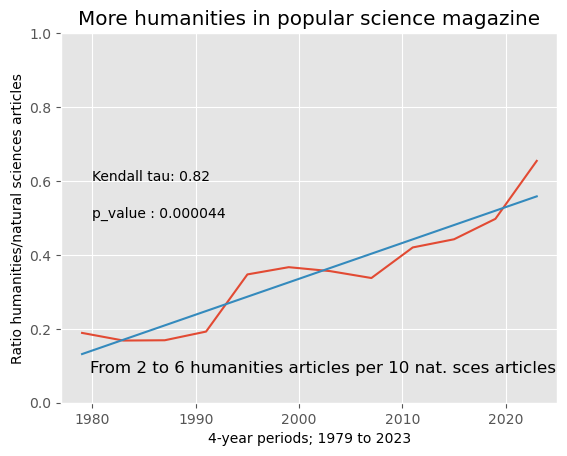

In [137]:
fig, ax = plt.subplots()
ax.plot(x1, r1)
ax.axis([1977, 2025, 0.0, 1.0])
m = np.polyfit(x1, r1, 1)
n = np.poly1d(m)
plt.plot(x1, n(x1))
ax.annotate('From 2 to 6 humanities articles per 10 nat. sces articles',
            xy=(65, 60), xycoords='figure points',
            fontsize=12)
ax.set(title = "More humanities in popular science magazine",
       ylabel = "Ratio humanities/natural sciences articles",
       xlabel = "4-year periods; 1979 to 2023")
ax.text(1980, 0.6, "Kendall tau: 0.82")
ax.text(1980, 0.5, "p_value : 0.000044")
fig.savefig("Increased humanities.png")